In [1]:
%pip install pandas numpy matplotlib scikit-learn scikit-optimize -q
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer


[notice] A new release of pip is available: 23.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Attempt to load the data generated by running data.ipynb
try:
    quali_practice_data = pd.read_csv('data/qualifying_data.csv')
    print("Data loaded successfully.")
    display(quali_practice_data.head())
except FileNotFoundError:
    print("Error: The file 'qualifying_data.csv' does not exist.")
    print("First you need to run data.ipynb.")
    quali_practice_data = None
    exit()

Data loaded successfully.


,driver_number,fastest_lap_time,fastest_lap_tyre_age,avg_lap_time,best_s1,best_s2,best_s3,avg_s1,avg_s2,avg_s3,...,fastest_lap_compound_INTERMEDIATE,fastest_lap_compound_MEDIUM,fastest_lap_compound_SOFT,fastest_lap_compound_WET,ran_SOFT,ran_HARD,ran_MEDIUM,ran_INTERMEDIATE,ran_WET,quali_position
0,77,91.793,0,111.004467,29.406,39.437,22.950,36.106111,46.795244,28.103111,...,False,False,True,False,True,False,True,False,False,12.0
1,4,91.570,0,110.083827,29.307,39.341,22.922,35.623385,46.888462,27.571981,...,False,False,True,False,True,False,True,False,False,11.0
2,24,91.586,0,111.504317,29.310,39.398,22.878,36.527976,46.677390,28.298951,...,False,False,True,False,True,False,True,False,False,13.0
3,11,91.078,0,108.753617,29.104,39.082,22.892,35.550915,46.188319,27.014383,...,False,False,True,False,True,True,True,False,False,2.0
4,21,92.605,0,113.304534,29.583,39.898,23.124,36.059897,48.889362,28.355276,...,False,False,True,False,True,False,True,False,False,19.0


In [3]:
# Drop high cardinality feature 'driver_number'
quali_practice_data = quali_practice_data.drop(columns=['driver_number'], errors='ignore')
print("High cardinality feature 'driver_number' dropped.")

High cardinality feature 'driver_number' dropped.


Starting Bayesian optimization...

Best parameters found:
max_depth: 30
max_features: 0.1
min_samples_leaf: 5
min_samples_split: 9
n_estimators: 1000

Model Performance:
Mean Squared Error: 21.2531
R² Score: 0.3474


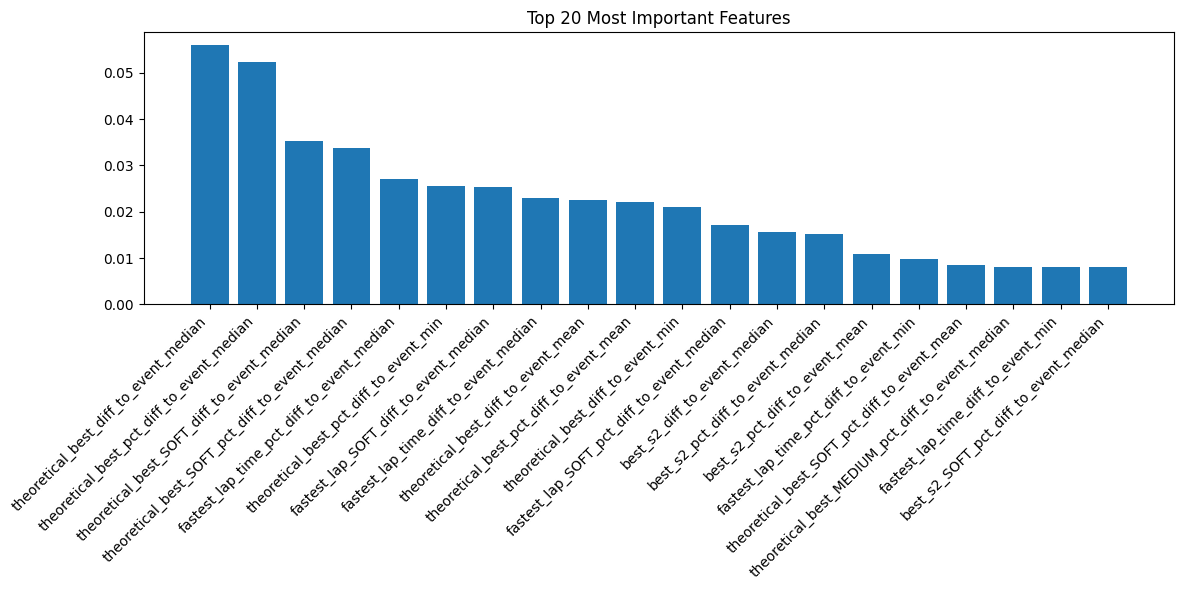

In [ ]:
# Separate features and target
y = quali_practice_data['quali_position']
X = quali_practice_data.drop('quali_position', axis=1)

# Split the data into train, test, and eval sets (70:15:15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_test, X_eval, y_test, y_eval = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% test, 15% eval

# Define the search space for hyperparameters
search_space = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(5, 30),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Real(0.1, 1.0)
}

# Create base random forest model
rf_model = RandomForestRegressor(random_state=42)

# Initialize BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=rf_model,
    search_spaces=search_space,
    n_iter=50,  
    cv=5,  
    n_jobs=-1, 
    random_state=42,
    scoring='neg_mean_squared_error'
)

# Fit the model
print("Starting Bayesian optimization...")
bayes_search.fit(X_train, y_train)

# Get the best parameters and model
print("\nBest parameters found:")
for param, value in bayes_search.best_params_.items():
    print(f"{param}: {value}")

# Get the best model
best_rf_model = bayes_search.best_estimator_

# Make predictions on test set
y_pred = best_rf_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'][:20], feature_importance['importance'][:20])
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

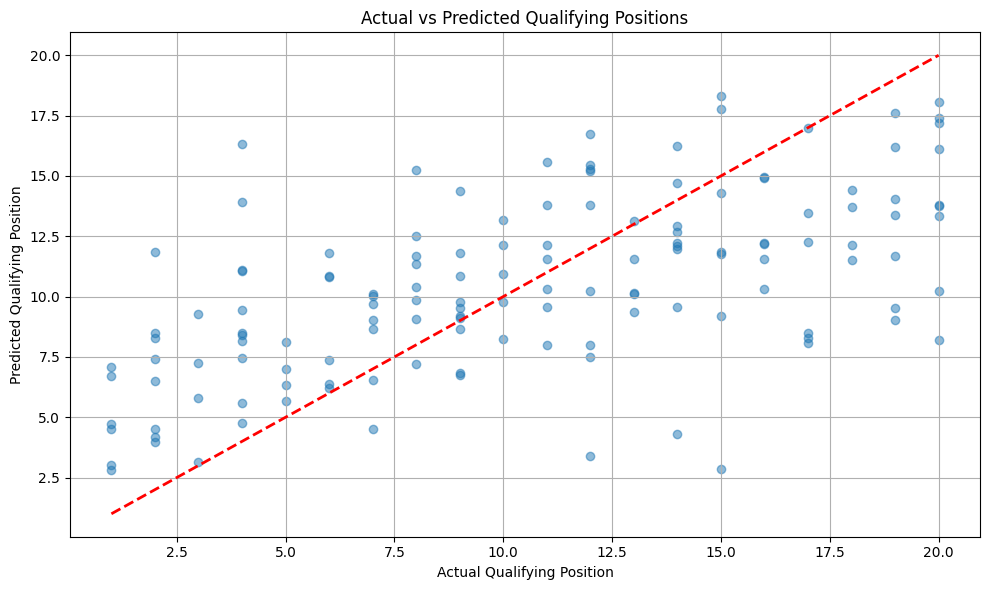